In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from flask import Flask, jsonify

In [17]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
prcp_table = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()

In [23]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_table)
prcp_df["date"] = pd.to_datetime(prcp_df["date"])

In [24]:
# Sort the dataframe by date
date_prcp_df = prcp_df.set_index("date")
date_prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


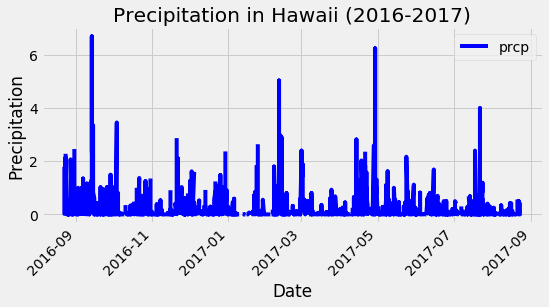

In [25]:
# Use Pandas Plotting with Matplotlib to plot the data
prec_plot = date_prcp_df.plot(figsize = (8, 4), rot=45, color="blue", sort_columns=True, use_index=True, legend=True, grid=True)
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.legend(loc="best")
plt.title("Precipitation in Hawaii (2016-2017)")
plt.show()

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
station_count

9

In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
busiest_station = session.query(Measurement.station, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
busiest_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
(maximum_station, maximum_count) = busiest_station[0]

In [30]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?
temp_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                     filter(Measurement.station == maximum_station).\
                     all()
temp_stats

[(54.0, 85.0, 71.66378066378067)]

In [31]:
station_query = session.query(Measurement.tobs).\
filter(Measurement.station == "USC00519281", Measurement.station == Station.station, Measurement.date >="2016-08-23", Measurement.date <="2017-08-23").\
all()

In [32]:
temperatures = [temp[0] for temp in station_query]

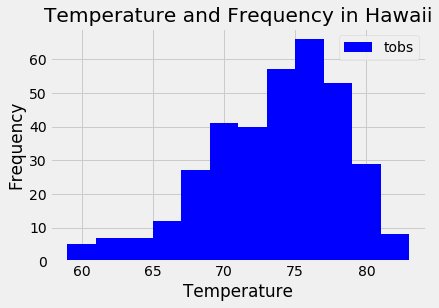

In [33]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temperatures, bins=12, color="blue")
plt.title("Temperature and Frequency in Hawaii")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
legend_label = ["tobs"]
plt.legend(legend_label)

# Step 2 - Climate App

# Routes

In [34]:
# Home page.
# List all routes that are available.
app = Flask(__name__)
@app.route('/api/v1.0/precipitation') 
def precipitation():
    print("Request for dates and temperatures from...")
    return "Dates and temperatures from last year."
    
    previous_temp = (session
                      .query(HI_measurements.tobs)
                      .filter(HI_measurements.date <= '2017-08-23')
                      .filter(HI_measurements.date >= '2016-08-23')
                      .order_by(HI_measurements.date)
                      .all())

    # Convert the query results to a Dictionary using date as the key and prcp as the value.
    temp_files = []
    for date in last_year_temp:
        dates ={}
        dates['date'] = HI_measurements.date
        dates['temperature'] = HI_measurements.tobs
        temp_files.append(date_dict)
    
    # Return the JSON representation of your dictionary.
    return jsonify(temp_files)

In [35]:
# /api/v1.0/stations
# Return a JSON list of stations from the dataset.
@app.route('/api/v1.0/stations') 
def stations():
    print("Requests for stations..")
    return "List of stations from the dataset."

    json_stations = (session
                      .query(HI_stations.stations)
                      .all())
    
    return jsonify(json_stations)

In [36]:
# /api/v1.0/tobs
# Query for the dates and temperature observations from a year from the last data point.
@app.route('/api/v1.0/tobs') 
def tobs():
    print("Request for list of temperature observations...")
    return "List of temperature observations from last year."
    
    # Return a JSON list of Temperature Observations (tobs) for the previous year.
    previous_year = (session
                      .query(HI_measurements.tobs)
                      .filter(HI_measurements.date <= '2017-08-23')
                      .filter(HI_measurements.date >= '2016-08-23')
                      .order_by(HI_measurements.tobs)
                      .all())
    
    return jsonify(previous_year)

In [37]:
# /api/v1.0/<start> and /api/v1.0/<start>/<end>
# Return a JSON list of the minimum temperature, the average temperature, 
# and the max temperature for a given start or start-end range.
@app.route('/api/v1.0/<start>)') 
def tobs_start():
    print("Requests for minimum, average, and maximum temperatures...")
    return "Minimum, average, and maximum temperatures."
    
    first_date = HI_measurements.date <= '2010-01-01'
    last_date = HI_measurements.date >= '2017-08-23'

    #When given the start only, calculate TMIN, TAVG, 
    # and TMAX for all dates greater than and equal to the start date.
    starting_date = (session
                       .query(HI_measurements.tobs)
                       .filter(HI_measurements.date.between(first_date, '2017-08-23'))
                       .all())
    
    tso_df = pd.DataFrame(starting_date)
    
    tmin = tso_df.min()
    tmax = tso_df.max()
    tavg = tso_df.avg()
    
    return jsonify(tmin, tmax, tavg)

In [38]:
@app.route('/api/v1.0/<start>/<end>') 
def given_range():
    
    print("Server received request for 'Min Temp, Avg Temp, Max Temp of a given start or date range' page...")
    return "Here is the list of Temperature information for the a given date range!"
    
    # When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start 
    # and end date inclusive.
    given_range = (session
                   .query(HI_measurements.tobs)
                   .filter(HI_measurements.date.between(first_date, last_date))
                   .all())
    
    tobs_df = pd.DataFrame(given_range)
    
    t2min = tobs_df.min()
    t2max = tobs_df.max()
    t2avg = tobs_df.avg()
    
    return jsonify(t2min, t2max, t2avg)

In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):

    # Docstring for the function `calc_temps`
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Create a function based on the dates below
print(calc_temps('2015-09-14', '2015-09-28'))

[(71.0, 78.06422018348624, 83.0)]


In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
date_times = calc_temps('2017-07-09','2017-07-25')
date_times

[(69.0, 78.44036697247707, 83.0)]

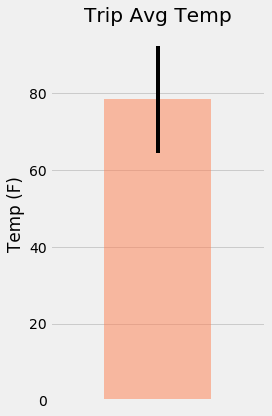

In [42]:
# Create a dataframe with the calculated tmin, tavg, and tmax values
temperature_df = pd.DataFrame(date_times, columns=['tmin', 'tavg', 'tmax'])


# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temperature_df.plot.bar(y='tavg', yerr=(temperature_df['tmax'] - temperature_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()

In [43]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def prec(start_date, end_date):
    
    """Information on precipation..
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    prec_querry = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*prec_querry).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(prec('2017-07-09','2017-07-25'))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.11), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.09), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]
